In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import re

In [4]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Dataset subset config

In [5]:
data_path = '/content/drive/MyDrive/dataset/9) Car-Hacking Dataset'

USE_SUBSET = True
MAX_NORMAL = 10_000
MAX_PER_ATTACK_FILE = 20_000
if USE_SUBSET:
    print(f"Using subset: max {MAX_NORMAL:,} normal, max {MAX_PER_ATTACK_FILE:,} per attack file")
else:
    print("Using full dataset")

Using subset: max 10,000 normal, max 20,000 per attack file


# Load Normal file

In [6]:
def parse_line(line):
    regex = r"Timestamp:\s*(\d+\.\d+)\s+ID:\s*(\w+)\s+000\s+DLC:\s*(\d+)\s+([\da-fA-F\s]+)"
    match = re.match(regex, line.strip())
    if match:
        timestamp = float(match.group(1))
        can_id = int(match.group(2), 16)
        dlc = int(match.group(3))
        data = [int(byte, 16) for byte in match.group(4).split()]
        data = (data + [0] * 8)[:8]
        return {
            'Timestamp': timestamp,
            'CAN_ID': can_id,
            'DLC': dlc,
            'DATA': data
        }
    return None

file_path = os.path.join(data_path, 'normal_run_data/normal_run_data.txt')
data = []

with open(file_path, 'r') as f:
    for line in f:
        if USE_SUBSET and len(data) >= MAX_NORMAL:
            break
        parsed = parse_line(line)
        if parsed:
            data.append(parsed)

df_normal = pd.DataFrame(data)
if USE_SUBSET:
    print(f"Normal: loaded {len(df_normal):,} rows (cap {MAX_NORMAL:,})")

for i in range(8):
    df_normal[f'DATA{i}'] = df_normal['DATA'].apply(lambda x: x[i] if i < len(x) else 0)

df_normal.drop(columns=['DATA'], inplace=True)
df_normal['Label'] = 'Normal'

Normal: loaded 10,000 rows (cap 10,000)


# Load Attack CSV Files

In [7]:
column_names = [
    'Timestamp', 'CAN_ID', 'DLC',
    'DATA0','DATA1','DATA2','DATA3','DATA4','DATA5','DATA6','DATA7',
    'Flag'
]

def convert_numeric_columns(df, columns_to_convert):
    for col in columns_to_convert:
        if col == 'CAN_ID' or col.startswith('DATA'):
            df[col] = df[col].astype(str).apply(lambda x: int(x, 16) if re.match(r'^[0-9a-fA-F]+$', x.strip()) else np.nan)
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df[col] = df[col].fillna(0).astype(int)
    return df

cols_to_process = ['CAN_ID', 'DLC'] + [f'DATA{i}' for i in range(8)]

def label_from_flag(flag_series, attack_name):
    """Label each row: Normal if Flag=='R', else attack type if Flag=='T'."""
    labels = []
    for v in flag_series.astype(str).str.strip().str.upper():
        if v == 'R':
            labels.append('Normal')
        elif v == 'T':
            labels.append(attack_name)
        else:
            labels.append('Normal')
    return labels

nrows = MAX_PER_ATTACK_FILE if USE_SUBSET else None

df_dos = pd.read_csv(os.path.join(data_path,'DoS_dataset.csv'),
                     header=None, names=column_names, nrows=nrows)
df_dos = convert_numeric_columns(df_dos, cols_to_process)
df_dos['Label'] = label_from_flag(df_dos['Flag'], 'DoS')
print("DoS df done:", len(df_dos), "rows")

df_fuzzy = pd.read_csv(os.path.join(data_path,'Fuzzy_dataset.csv'),
                       header=None, names=column_names, nrows=nrows)
df_fuzzy = convert_numeric_columns(df_fuzzy, cols_to_process)
df_fuzzy['Label'] = label_from_flag(df_fuzzy['Flag'], 'Fuzzy')
print("Fuzzy df done:", len(df_fuzzy), "rows")

df_gear = pd.read_csv(os.path.join(data_path,'gear_dataset.csv'),
                      header=None, names=column_names, nrows=nrows)
df_gear = convert_numeric_columns(df_gear, cols_to_process)
df_gear['Label'] = label_from_flag(df_gear['Flag'], 'Gear')
print("gear df done:", len(df_gear), "rows")

df_rpm = pd.read_csv(os.path.join(data_path,'RPM_dataset.csv'),
                     header=None, names=column_names, nrows=nrows)
df_rpm = convert_numeric_columns(df_rpm, cols_to_process)
df_rpm['Label'] = label_from_flag(df_rpm['Flag'], 'RPM')
print("RPM df done:", len(df_rpm), "rows")

DoS df done: 20000 rows
Fuzzy df done: 20000 rows
gear df done: 20000 rows
RPM df done: 20000 rows


# Combining Data

In [8]:
full_df = pd.concat([df_normal, df_dos, df_fuzzy, df_gear, df_rpm], ignore_index=True)
features = ['CAN_ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']

# EDA

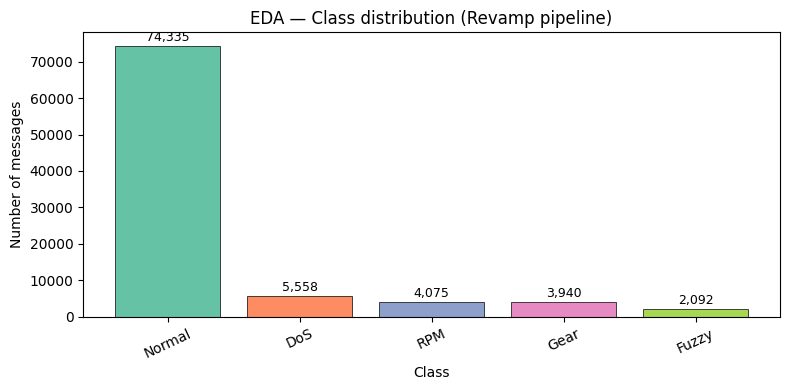

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

fig, ax = plt.subplots(figsize=(8, 4))
counts = full_df['Label'].value_counts()
colors = sns.color_palette("Set2", n_colors=len(counts))
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Class')
ax.set_ylabel('Number of messages')
ax.set_title('EDA — Class distribution (Revamp pipeline)')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts.values)*0.008,
            f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

N_FEATURES = len(features)
X = full_df[features].values
y = full_df['Label'].values

# Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

le_full = LabelEncoder()
y_encoded_full = le_full.fit_transform(y)
y_cat_full = to_categorical(y_encoded_full)

X_train, X_test, y_train_full, y_test_full = train_test_split(
    X, y_cat_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded_full
)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_lstm = X_train.reshape((X_train.shape[0], 1, N_FEATURES))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, N_FEATURES))

# Stage 01

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(RANDOM_STATE)

normal_label_full = le_full.transform(['Normal'])[0]
attack_classes = ['DoS', 'Fuzzy', 'Gear', 'RPM']
le_attack = LabelEncoder()
le_attack.fit(attack_classes)

train_attack_mask = np.argmax(y_train_full, axis=1) != normal_label_full
X_train_attack = X_train[train_attack_mask]
y_train_attack_labels = np.argmax(y_train_full, axis=1)[train_attack_mask]
y_train_attack = le_attack.transform(le_full.inverse_transform(y_train_attack_labels))
y_train_attack_cat = to_categorical(y_train_attack, num_classes=len(attack_classes))
X_train_attack_lstm = X_train_attack.reshape((X_train_attack.shape[0], 1, N_FEATURES))

inputs = Input(shape=(1, N_FEATURES))
x = LSTM(128, return_sequences=False)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(len(attack_classes), activation='softmax')(x)
attack_classifier = Model(inputs, outputs)
attack_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight
classes_attack = np.unique(y_train_attack)
class_weights_attack = compute_class_weight('balanced', classes=classes_attack, y=y_train_attack)
class_weights_attack_dict = dict(zip(classes_attack, class_weights_attack))

history_attack = attack_classifier.fit(
    X_train_attack_lstm, y_train_attack_cat,
    epochs=30, batch_size=64, validation_split=0.1, verbose=2,
    class_weight=class_weights_attack_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
177/177 - 7s - 39ms/step - accuracy: 0.9800 - loss: 0.1048 - val_accuracy: 1.0000 - val_loss: 0.6598
Epoch 2/30
177/177 - 2s - 9ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.1341
Epoch 3/30
177/177 - 2s - 10ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 4/30
177/177 - 1s - 8ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 8.0723e-04
Epoch 5/30
177/177 - 1s - 7ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 2.0496e-04
Epoch 6/30
177/177 - 1s - 7ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.5375e-04
Epoch 7/30
177/177 - 1s - 7ms/step - accuracy: 1.0000 - loss: 5.5869e-04 - val_accuracy: 1.0000 - val_loss: 7.7739e-05
Epoch 8/30
177/177 - 1s - 7ms/step - accuracy: 0.9999 - loss: 9.3370e-04 - val_accuracy: 1.0000 - val_loss: 3.4816e-05
Epoch 9/30
177/177 - 1s - 7ms/step - accuracy: 1.0000 - loss: 2.3320e-04 - val_acc

# Stage 02

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(RANDOM_STATE)
X_train_normal = X_train[np.argmax(y_train_full, axis=1) == normal_label_full]
input_dim = X_train_normal.shape[1]

input_ae = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_ae)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_ae, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_autoencoder = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=30, batch_size=64, validation_split=0.1, verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
837/837 - 9s - 10ms/step - loss: 0.0093 - mae: 0.0534 - val_loss: 9.0490e-04 - val_mae: 0.0205
Epoch 2/30
837/837 - 2s - 3ms/step - loss: 0.0013 - mae: 0.0256 - val_loss: 5.5381e-04 - val_mae: 0.0164
Epoch 3/30
837/837 - 2s - 3ms/step - loss: 8.9915e-04 - mae: 0.0213 - val_loss: 3.6918e-04 - val_mae: 0.0129
Epoch 4/30
837/837 - 3s - 3ms/step - loss: 7.0851e-04 - mae: 0.0189 - val_loss: 2.9239e-04 - val_mae: 0.0116
Epoch 5/30
837/837 - 3s - 3ms/step - loss: 5.9316e-04 - mae: 0.0172 - val_loss: 2.5999e-04 - val_mae: 0.0108
Epoch 6/30
837/837 - 2s - 3ms/step - loss: 5.0866e-04 - mae: 0.0159 - val_loss: 2.1829e-04 - val_mae: 0.0101
Epoch 7/30
837/837 - 2s - 3ms/step - loss: 4.4866e-04 - mae: 0.0149 - val_loss: 2.2217e-04 - val_mae: 0.0103
Epoch 8/30
837/837 - 2s - 3ms/step - loss: 4.0397e-04 - mae: 0.0141 - val_loss: 2.0077e-04 - val_mae: 0.0098
Epoch 9/30
837/837 - 3s - 3ms/step - loss: 3.6872e-04 - mae: 0.0135 - val_loss: 1.8000e-04 - val_mae: 0.0092
Epoch 10/30
837/837 - 3s -

In [13]:
reconstructions = autoencoder.predict(X_train_normal, verbose=0)
train_loss = np.mean(np.square(X_train_normal - reconstructions), axis=1)
threshold = np.mean(train_loss) + 3 * np.std(train_loss)
print("Stage 2 — Reconstruction threshold (Normal vs Not Normal):", threshold)

Stage 2 — Reconstruction threshold (Normal vs Not Normal): 0.0005634641601958885


# Prediction Fucntion

In [14]:
def revamp_predict(sample, scaled=True):

    if not scaled:
        sample = scaler.transform(sample.reshape(1, -1))
    else:
        sample = np.asarray(sample).reshape(1, -1)

    # Stage 1: Attack-type classification
    sample_lstm = sample.reshape((1, 1, N_FEATURES))
    pred = attack_classifier.predict(sample_lstm, verbose=0)
    class_idx = np.argmax(pred)
    attack_type = attack_classes[class_idx]

    # Stage 2: Autoencoder
    recon = autoencoder.predict(sample, verbose=0)
    loss = np.mean(np.square(sample - recon))
    if loss <= threshold:
        return "Normal"
    return attack_type

# Evaluation

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

revamp_results = [revamp_predict(X_test[i], scaled=True) for i in range(len(X_test))]
print("revamp_results loaded")

true_labels = le_full.inverse_transform(np.argmax(y_test_full, axis=1))
print("print_labels loaded")

revamp_accuracy = accuracy_score(true_labels, revamp_results)
print("Revamp pipeline accuracy:", revamp_accuracy)


revamp_results loaded
print_labels loaded
Revamp pipeline accuracy: 0.9278333333333333


# Visualization and Result

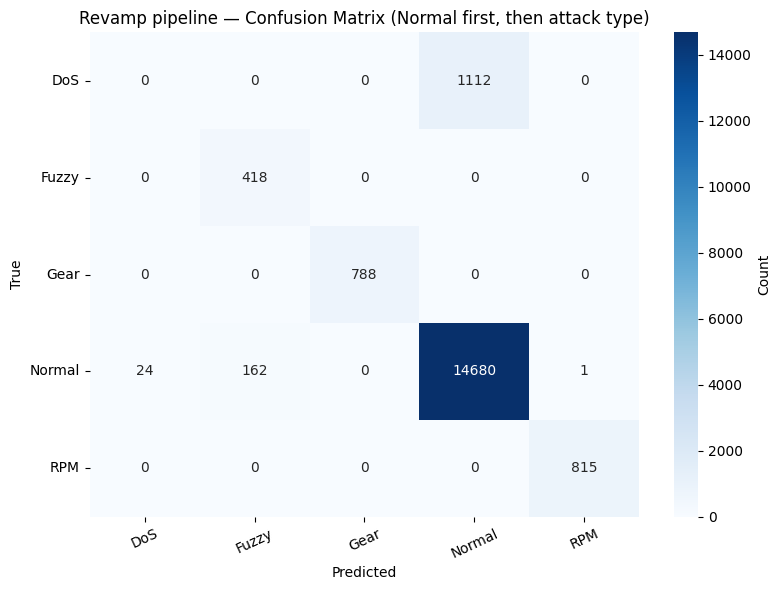


--- Revamp pipeline — Classification Report ---
              precision    recall  f1-score   support

         DoS       0.00      0.00      0.00      1112
       Fuzzy       0.72      1.00      0.84       418
        Gear       1.00      1.00      1.00       788
      Normal       0.93      0.99      0.96     14867
         RPM       1.00      1.00      1.00       815

    accuracy                           0.93     18000
   macro avg       0.73      0.80      0.76     18000
weighted avg       0.87      0.93      0.90     18000



In [16]:
all_labels_revamp = list(le_full.classes_)
cm = confusion_matrix(true_labels, revamp_results, labels=all_labels_revamp)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=all_labels_revamp, yticklabels=all_labels_revamp,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Revamp pipeline — Confusion Matrix (Normal first, then attack type)')
plt.xticks(rotation=25)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Revamp pipeline — Classification Report ---")
print(classification_report(true_labels, revamp_results))